In [3]:
import os
import argparse
import json
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman') 

import umap                        
import seaborn as sns 
from utils.util import find_max_epoch, print_size, calc_diffusion_hyperparams
from utils.util import get_mask_mnr, get_mask_bm, get_mask_rm, get_mask_mcar
from imputers.SSSDS4Imputer import SSSDS4Imputer
import time
import gc
from tqdm import tqdm
from pypots.utils.metrics import calc_mse,calc_rmse,calc_mae
import os

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('-c', '--config', type=str, default='./config/config_SSSDS4-sp500.json') 
                                                                                                                      
args = parser.parse_args(args=[])
print(args)

with open(args.config) as f:
    data = f.read()

config = json.loads(data)

config["diffusion_config"]['T'] = 200
print(config)

Namespace(config='./config/config_SSSDS4-sp500.json')
{'diffusion_config': {'T': 200, 'beta_0': 0.0001, 'beta_T': 0.02}, 'wavenet_config': {'in_channels': 6, 'out_channels': 6, 'num_res_layers': 36, 'res_channels': 128, 'skip_channels': 128, 'diffusion_step_embed_dim_in': 128, 'diffusion_step_embed_dim_mid': 512, 'diffusion_step_embed_dim_out': 512, 's4_lmax': 100, 's4_d_state': 64, 's4_dropout': 0.0, 's4_bidirectional': 1, 's4_layernorm': 1}, 'train_config': {'output_directory': './results/sp500/90', 'ckpt_iter': 'max', 'iters_per_ckpt': 500, 'iters_per_logging': 500, 'n_iters': 1000, 'learning_rate': 0.0002, 'only_generate_missing': 1, 'use_model': 2, 'masking': 'rm', 'missing_k': 20}, 'trainset_config': {'train_data_path': './datasets/sp500.npy', 'test_data_path': './datasets/sp500.npy', 'segment_length': 100, 'sampling_rate': 100}, 'gen_config': {'output_directory': './results/sp500/90', 'ckpt_path': './results/sp500/90/'}}


In [5]:
train_config = config["train_config"]  # training parameters

global trainset_config
trainset_config = config["trainset_config"]  # to load trainset


global diffusion_config
diffusion_config = config["diffusion_config"]  # basic hyperparameters


global diffusion_hyperparams
diffusion_hyperparams = calc_diffusion_hyperparams(
                      **diffusion_config)  

global model_config

# choose dataset

In [6]:
data_name = 'sp500'
# data_name = 'ETTh1'
# data_name = 'energy'
# data_name = 'mujoco'

if data_name == 'sp500':
    trainset_config['train_data_path'] = "./datasets/sp500.npy"
    
if data_name == 'energy':
    trainset_config['train_data_path'] = "./datasets/energy.npy"
    
if data_name == 'ETTh1':
    trainset_config['train_data_path'] = "./datasets/ETTh1.npy"
    
if data_name == 'mujoco':
    trainset_config['train_data_path'] = "./datasets/MuJoCo.npy"

print(trainset_config)

model_config = config['wavenet_config']
print(train_config)
print(model_config)


if data_name == 'sp500':
    model_config['in_channels'] =  6   
    model_config['out_channels'] = 6   
    
if data_name == 'energy':
    model_config['in_channels'] =  26   
    model_config['out_channels'] = 26  
    
if data_name == 'ETTh1':
    model_config['in_channels'] =  7   
    model_config['out_channels'] = 7  
    
if data_name == 'mujoco':
    model_config['in_channels'] =  14   
    model_config['out_channels'] = 14  



model_config['num_res_layers'] = 18            

if data_name == 'energy':
    model_config['res_channels'] = 256            
    model_config['skip_channels'] =256 
    
else:
    model_config['res_channels'] = 256           
    model_config['skip_channels'] = 256
    
print(model_config)

{'train_data_path': './datasets/sp500.npy', 'test_data_path': './datasets/sp500.npy', 'segment_length': 100, 'sampling_rate': 100}
{'output_directory': './results/sp500/90', 'ckpt_iter': 'max', 'iters_per_ckpt': 500, 'iters_per_logging': 500, 'n_iters': 1000, 'learning_rate': 0.0002, 'only_generate_missing': 1, 'use_model': 2, 'masking': 'rm', 'missing_k': 20}
{'in_channels': 6, 'out_channels': 6, 'num_res_layers': 36, 'res_channels': 128, 'skip_channels': 128, 'diffusion_step_embed_dim_in': 128, 'diffusion_step_embed_dim_mid': 512, 'diffusion_step_embed_dim_out': 512, 's4_lmax': 100, 's4_d_state': 64, 's4_dropout': 0.0, 's4_bidirectional': 1, 's4_layernorm': 1}
{'in_channels': 6, 'out_channels': 6, 'num_res_layers': 18, 'res_channels': 256, 'skip_channels': 256, 'diffusion_step_embed_dim_in': 128, 'diffusion_step_embed_dim_mid': 512, 'diffusion_step_embed_dim_out': 512, 's4_lmax': 100, 's4_d_state': 64, 's4_dropout': 0.0, 's4_bidirectional': 1, 's4_layernorm': 1}


In [7]:
for key in diffusion_hyperparams:
    if key != "T":
        diffusion_hyperparams[key] = diffusion_hyperparams[key].cuda()
        

dh = diffusion_hyperparams

T, Alpha, Alpha_bar, Sigma = dh["T"], dh["Alpha"], dh["Alpha_bar"], dh["Sigma"]
Beta = 1 - Alpha

print(T)

def get_acc_point(alphas_hat):
        abs_dist = torch.abs(torch.sqrt(alphas_hat) - 0.5)
        return abs_dist.argmin() + 1
    
T_acc = get_acc_point(Alpha_bar).item()
print( T_acc )

abs_dist = torch.abs(torch.sqrt(Alpha_bar[165]) - 0.5)

200
166


In [8]:
load_data = np.load(trainset_config['train_data_path'])
np.random.shuffle(load_data)
train_data = load_data

Number, Length, Attribute  = train_data.shape
print(Number, Length, Attribute)

5775 30 6


In [9]:
def resfusion_x0_to_xt(x_0: torch.Tensor, alpha_hat_t: torch.Tensor, residual_term: torch.Tensor, noise: torch.Tensor) \
        -> torch.Tensor:
    return (torch.sqrt(alpha_hat_t) * x_0 + (1 - torch.sqrt(alpha_hat_t)) * residual_term
            + torch.sqrt(1 - alpha_hat_t) * noise)


def ddpm_x0_to_xt(x_0: torch.Tensor, alpha_hat_t: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
    return torch.sqrt(alpha_hat_t) * x_0 + torch.sqrt(1 - alpha_hat_t) * noise


def std_normal(size):
    return torch.normal(0, 1, size=size).cuda()


# choose missing rate and mechanism

In [10]:
mr = 0.3
mechanism = 'mcar'  # or 'mnr'
missing_length = int( mr * Length )

# confirm required model

In [11]:
print(data_name, mechanism, mr)

sp500 mcar 0.3


# Load Distillation model

In [12]:
gc.collect()
torch.cuda.empty_cache()

resnoise_unet = SSSDS4Imputer(**model_config).cuda()
resnoise_unet.load_state_dict(torch.load( "./checkpoint/{}_resnoise_{}{}.pth".format( data_name, mechanism, mr) ))

<All keys matched successfully>

# prepare dataset

In [13]:
train_data = np.load(trainset_config['train_data_path'])
np.random.shuffle(train_data)
print(train_data.shape)

train_data = torch.from_numpy(train_data).float().cuda()

size = (train_data.shape[0], Length, Attribute )
noise = std_normal(size)

Mask = torch.empty([0, Length, Attribute])    
print( Mask.shape)
print(mr, missing_length)


for i in range(train_data.shape[0]):
    if mechanism == 'mcar':
        one_mask = get_mask_mcar( train_data[0], mr)  
    else:
        one_mask = get_mask_mnr( train_data[0], missing_length) 

    one_mask = one_mask.unsqueeze(0)   
    Mask = torch.row_stack([Mask, one_mask])

Mask = Mask.float().cuda()


X_0_hat = train_data.reshape(-1, Length, Attribute) * Mask
alpha_hat = Alpha_bar[T_acc - 1].reshape(-1, 1, 1).cuda() 
X_Tacc = ddpm_x0_to_xt(X_0_hat, alpha_hat, noise)    
print(X_Tacc.shape)

(5775, 30, 6)
torch.Size([0, 30, 6])
0.3 9
torch.Size([5775, 30, 6])


# Resnoise sampling and running time

In [14]:
X = X_Tacc.permute(0, 2, 1)
X = X*(1-Mask.permute(0, 2, 1)) + X_0_hat.permute(0, 2, 1)
print(X.shape)

start_time = time.time()
with torch.no_grad():      
        for t in tqdm( range( T_acc - 1, -1, -1) ):  

            diffusion_steps = (t * torch.ones((size[0], 1))).cuda()
    
            epsilon_theta = resnoise_unet((X, X_0_hat.permute(0, 2, 1), Mask.permute(0, 2, 1), diffusion_steps,)) 
            
            
            alpha = Alpha[t].reshape(-1, 1, 1).cuda() 
            beta = Beta[t].reshape(-1, 1, 1).cuda() 
            alpha_hat = Alpha_bar[t].reshape(-1, 1, 1).cuda()      
            sigma = Sigma[t].reshape(-1, 1, 1).cuda()      
            
            X = ( X - ( (1 - alpha) / ( torch.sqrt(1 - alpha_hat) ) * epsilon_theta) )  / torch.sqrt(alpha)
            
            if t > 0:  
                X = X + sigma * std_normal( X.shape )
                                
            X = X*(1-Mask.permute(0, 2, 1)) + X_0_hat.permute(0, 2, 1)
    
DDPM_res = X

end_time = time.time()
execution_time = end_time - start_time  
print('running time', execution_time) 

torch.Size([5775, 6, 30])


100%|████████████████████████████████████████████████████████████████████████████████| 166/166 [05:26<00:00,  1.97s/it]

running time 326.4490466117859


# RMSE MAE

In [15]:
result = X.permute(0, 2, 1)
rmse = calc_rmse(result, train_data, 1-Mask).cpu()
mae = calc_mae(result, train_data, 1-Mask).cpu() 
print( 'RMSE', rmse )
print( 'MAE', mae)

RMSE tensor(0.0082)
MAE tensor(0.0033)


# visualization

In [16]:
def visualization(ori, gen):
    Number = ori.shape[0]
    max_sample = min([4000, Number])      
    idx = np.random.permutation(Number)[ :max_sample]
    ori1 = np.asarray(ori)[idx]
    gen1 = np.asarray(gen)[idx]
    ori1 = np.mean(ori1, 2) 
    gen1 = np.mean(gen1, 2) 
    concat_data = np.concatenate((ori1, gen1), axis=0)

    pca = PCA(2)     
    pca_res = pca.fit_transform(concat_data)

    tsne = TSNE(n_components=2, verbose=1, perplexity=40,random_state=20,n_iter=500) 
    tsne_res = tsne.fit_transform(concat_data) 

    umap_ = umap.UMAP(random_state=42)
    umap_res = umap_.fit_transform(concat_data)
    
    
    fig = plt.figure(figsize=(19,4))
    plt.subplot(1,4,1)
    
    plt.scatter(pca_res[:2000,0],pca_res[:2000,1], s=15, c='#ff7f0e')
    plt.scatter(pca_res[max_sample:max_sample+2000,0],pca_res[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
    plt.xlabel('(a)',fontsize=25)
    
    plt.subplot(1,4,2)
    plt.scatter(tsne_res[:2000,0],tsne_res[:2000,1],  s=15,  c='#ff7f0e')
    plt.scatter(tsne_res[max_sample:max_sample+2000,0],tsne_res[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
    plt.xlabel('(b)',fontsize=25)

    plt.subplot(1,4,3)
    plt.scatter(umap_res[:2000, 0], umap_res[:2000, 1],  cmap='Spectral', s=15,  c='#ff7f0e')
    plt.scatter(umap_res[max_sample:max_sample+2000, 0], umap_res[max_sample:max_sample+2000, 1],  cmap='Spectral', s=15, c='#1f77b4')
    plt.xlabel('(c)',fontsize=25)

    
    plt.subplot(1,4,4)
    sns.distplot(ori[:,:,1], hist=False, color = '#ff7f0e' )
    sns.distplot(gen[:,:,1], hist=False, color = '#1f77b4' )  
    plt.xlabel('(d)',fontsize=25)

C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.000s...
[t-SNE] Computed neighbors for 8000 samples in 0.223s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.019307
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.619736
[t-SNE] KL divergence after 500 iterations: 1.024292


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\PC123\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\PC123\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\PC123\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `k

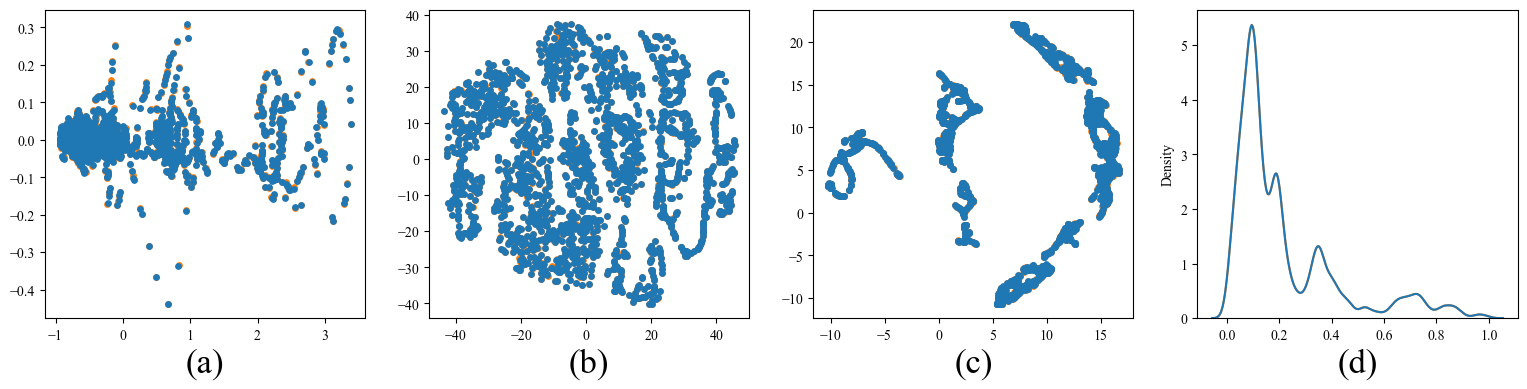

In [17]:
visualization( train_data.cpu(), result.cpu() )

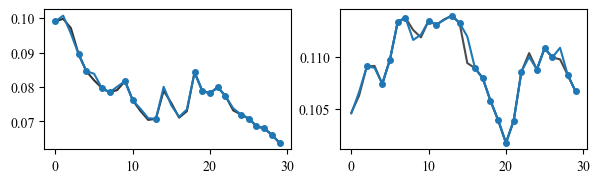

In [18]:
ob = train_data.cpu() * Mask.cpu()
ob[ob==0]=np.nan

sample_ind1 = np.random.randint( 0, Number )
attr_ind1 = np.random.randint( 0, Attribute )

sample_ind2 = np.random.randint( 0, Number )
attr_ind2 = np.random.randint( 0, Attribute )


fig = plt.figure(figsize=(7,4))
plt.subplot(2,2,1)
plt.plot(result.cpu()[sample_ind1][:,attr_ind1], c='k', alpha=0.8) 
plt.plot(train_data.cpu()[sample_ind1][:,attr_ind1], c='#1f77b4', ) 
plt.plot(ob[sample_ind1][:,attr_ind1], c='#1f77b4', alpha=1, marker='o', markersize='4') 


plt.subplot(2,2,2)
plt.plot(result.cpu()[sample_ind2][:,attr_ind2], c='k', alpha=0.7) 
plt.plot(train_data.cpu()[sample_ind2][:,attr_ind2], c='#1f77b4') 
plt.plot(ob[sample_ind2][:,attr_ind2], c='#1f77b4',  marker='o',alpha=1, markersize='4') 